<a href="https://colab.research.google.com/github/JordanHanotiaux/Internship/blob/main/Benchmark_YOLOE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install ultralytics

%pip install supervision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import zipfile
import json
import re
import yaml
import requests
import torch
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
import urllib.request

from PIL import Image
from io import BytesIO
#from google.colab import drive
from ultralytics import YOLOE
from tqdm import tqdm
from ultralytics import YOLOE
from sklearn.metrics import average_precision_score
from collections import defaultdict
import matplotlib.patches as patches


In [3]:
# Import Lvis minival dataset.

try:
    from google.colab import drive
    drive.mount('/content/drive')
    minival_path = "/content/drive/MyDrive/minival.txt"
    lvis_zip_path = "/content/drive/MyDrive/lvis_v1_val.json.zip"
except ImportError:
    # Not running in Colab, set your local paths here
    minival_path = "../Dataset/minival.txt"
    lvis_zip_path = "../Dataset/lvis_v1_val.json.zip"

with open(minival_path, "r") as f:
    minival_ids = set(int(line.strip().split('/')[-1].split('.')[0]) for line in f)

images = []
annotations = []
categories = []
category_ids_in_minival = set()

# Extract and filter LVIS data from the ZIP archive
with zipfile.ZipFile(lvis_zip_path, "r") as zf:
    with zf.open("lvis_v1_val.json", "r") as f:
        lvis_data = json.load(f)

    for img in lvis_data["images"]:
        if img["id"] in minival_ids:
            images.append(img)

    for ann in lvis_data["annotations"]:
        if ann["image_id"] in minival_ids:
            annotations.append(ann)
            category_ids_in_minival.add(ann['category_id'])

    for cat in lvis_data["categories"]:
        if cat['id'] in category_ids_in_minival:
            categories.append(cat)

# Reconstruct filtered LVIS structure
lvis_val = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

# Save to JSON
with open("../Dataset/lvis_minival_only.json", "w") as f:
    json.dump(lvis_val, f)

print(f"Images : {len(images)}")
print(f"Annotations : {len(annotations)}")
print(f"Categories : {len(categories)}")

Images : 4809
Annotations : 50672
Categories : 804


In [4]:
# Create categories's set of Lvis dataset

def clean_category(name):
    # Delete pattern as _(xxx)
    name = re.sub(r'_\([^)]*\)', '', name)
    # Replace remaining underscores by spaces
    name = re.sub(r'_', ' ', name)
    name = name.lower()
    return name.strip()

lvis_categories = set()
for cat in lvis_val['categories']:
    cleaned = clean_category(cat['name'])
    lvis_categories.add(cleaned)

print("Nombre de catégories (LVIS dataset):", len(lvis_categories))

Nombre de catégories (LVIS dataset): 802


In [5]:
# Import Object365 dataset

object365_categories_processed = set()
with open('../Dataset/object365_categories.txt', 'r', encoding='utf-8') as f:
    for line in f:
        category = line.strip()
        if category:
            object365_categories_processed.add(category)
print(f"Nombre de catégories dans object365_categories.txt : {len(object365_categories_processed)}")

# Calcul des catégories communes et uniques
seen_categories = lvis_categories.intersection(object365_categories_processed)
print("Nombre de catégories communes (LVIS-Object365) :", len(seen_categories))

unseen_categories = lvis_categories.difference(object365_categories_processed)
print("Nombre de catégories non communes (LVIS-Object365) :", len(unseen_categories))

Nombre de catégories dans object365_categories.txt : 381
Nombre de catégories communes (LVIS-Object365) : 186
Nombre de catégories non communes (LVIS-Object365) : 616


In [6]:
# Import GoldG dataset

goldg_categories = set()
with open('../Dataset/GoldG_category.txt', 'r', encoding='utf-8') as f:
    for line in f:
        category = line.strip()
        if category:
            goldg_categories.add(category)
print(f"Nombre de catégories dans GoldG.txt : {len(goldg_categories)}")


# Match unseen categories with annotated phrases (grounding categories)
example = 0
for category in unseen_categories.copy():
    for phrase in goldg_categories:
      if all(word in phrase.split() for word in category.split()):
        if example < 5:
          print("Catégorie trouvée :", category)
          print("Phrase trouvée :", phrase)
          example += 1
        unseen_categories.discard(category)
        seen_categories.add(category)
        break

print("Nombre de catégories communes(LVIS-Object 365-GoldG dataset):", len(seen_categories))
print("Nombre de catégories non communes (LVIS-Object 365-GoldG dataset):", len(unseen_categories))

Nombre de catégories dans GoldG.txt : 139132
Catégorie trouvée : bowling ball
Phrase trouvée : her bowling ball roll
Catégorie trouvée : cookie
Phrase trouvée : donut with cookie crumble topping
Catégorie trouvée : green bean
Phrase trouvée : can of green giant bean
Catégorie trouvée : cracker
Phrase trouvée : strawberry on a cracker
Catégorie trouvée : reflector
Phrase trouvée : reflector on side of scooter
Nombre de catégories communes(LVIS-Object 365-GoldG dataset): 752
Nombre de catégories non communes (LVIS-Object 365-GoldG dataset): 50


In [7]:
# Predict AP50 score for each category across the LVIs minival dataset

def get_category_mapping(data):
    """
        Creates a mapping from category ID to category name.

        Args:
            data (dict): JSON Dataset.

        Returns:
            dict: Mapping from category ID (int) to category name (str).
    """
    return {cat['id']: cat['name'] for cat in data['categories']}

def get_annotations_by_image(data, image_id):
    """
        Retrieves all annotations associated with a specific image.

        Args:
            data (dict): JSON Dataset.
            image_id (int): ID of the image.

        Returns:
            list: List of annotation dicts for the specified image.
    """
    return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

def group_boxes_by_category(annotations, id_to_name):
    """
        Groups bounding boxes by their category names.

        Args:
            annotations (list): List of annotation dicts for a single image.
            id_to_name (dict): Mapping from category ID to category name.

        Returns:
            dict: Dictionary mapping category name to a list of bounding boxes.
    """
    category_to_boxes = defaultdict(list)
    for ann in annotations:
        category_name = id_to_name[ann['category_id']]
        category_to_boxes[category_name].append(ann['bbox'])
    return category_to_boxes

def compute_iou(boxA, boxB):
    """
        Computes the Intersection over Union (IoU) between two bounding boxes.

        Args:
            boxA (list): First box in XYXY format [x1, y1, x2, y2].
            boxB (list): Second box in XYXY format [x1, y1, x2, y2].

        Returns:
            float: IoU score between the two boxes.
    """
    ix1 = max(boxA[0], boxB[0])
    iy1 = max(boxA[1], boxB[1])
    ix2 = min(boxA[2], boxB[2])
    iy2 = min(boxA[3], boxB[3])
    inter = max(ix2 - ix1, 0) * max(iy2 - iy1, 0)

    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - inter
    return inter / union if union > 0 else 0

def convert_bbox_xywh_to_xyxy(bbox):
    """
        Converts bounding box from [x, y, width, height] to [x1, y1, x2, y2].

        Args:
            bbox (list): Bounding box in XYWH format.

        Returns:
            list: Bounding box in XYXY format.
    """
    x, y, w, h = bbox
    return [x, y, x + w, y + h]

def compute_ap(gt_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    """
        Computes Average Precision (AP) at a given IoU threshold for a single category.

        Args:
            gt_boxes (list): Ground-truth bounding boxes in XYWH format.
            pred_boxes (list): Predicted boxes in XYXY format.
            pred_scores (list): Confidence scores for each predicted box.
            iou_threshold (float): IoU threshold to consider a prediction correct.

        Returns:
            float: Average Precision (AP) score.
    """
    if not pred_boxes:
        return 0.0

    ious = []
    for pred_box in pred_boxes:
        iou_max = 0
        for gt_box in gt_boxes:
            iou = compute_iou(pred_box, convert_bbox_xywh_to_xyxy(gt_box))
            iou_max = max(iou_max, iou)
        ious.append(iou_max)

    y_true = [1 if iou >= iou_threshold else 0 for iou in ious]
    return average_precision_score(y_true, pred_scores) if any(y_true) else 0.0

def process_image(image, data, model, id_to_name, thresholds, ap50_scores):
    """
        Runs inference on a single image, computes AP scores across all thresholds
        for each ground-truth category, and updates the AP score dictionary.

        Args:
            image (dict): Image metadata dict from JSON dataset.
            data (dict): JSON dataset.
            model (YOLOE): Initialized detection model.
            id_to_name (dict): Category ID to name mapping.
            thresholds (list): List of confidence thresholds to evaluate.
            ap50_scores (defaultdict): Nested dict to store AP scores.
    """
    response = requests.get(image['coco_url'])
    img = Image.open(BytesIO(response.content)).convert("RGB")

    annotations = get_annotations_by_image(data, image['id'])
    category_to_boxes = group_boxes_by_category(annotations, id_to_name)
    categories = list(category_to_boxes.keys())

    model.set_classes(categories, model.get_text_pe(categories))
    result = model.predict(img, conf=0.001, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)

    for category_name, gt_boxes in category_to_boxes.items():
        for threshold in thresholds:
            pred_boxes = []
            pred_scores = []

            for label, score, box in zip(detections['class_name'], detections.confidence, detections.xyxy):
                if label == category_name and score >= threshold:
                    pred_boxes.append(box)
                    pred_scores.append(score)

            ap = compute_ap(gt_boxes, pred_boxes, pred_scores)
            ap50_scores[category_name][threshold].append(ap)

def evaluate_dataset(data, model_path, max_images=5):
    """
        Evaluates a detection model on a subset of the JSON dataset by computing
        AP@0.5 scores per category across multiple confidence thresholds.

        Args:
            data (dict): JSON dataset.
            model_path (str): Path to the pretrained YOLOE model.
            max_images (int): Maximum number of images to evaluate.

        Returns:
            dict: Nested dictionary {category_name: {threshold: [AP scores]}}.
    """
    ap50_scores = defaultdict(lambda: defaultdict(list))
    id_to_name = get_category_mapping(data)
    thresholds = [round(x, 1) for x in np.arange(0.0, 1.01, 0.1)]

    for image in tqdm(data['images'][:max_images]):
        model = YOLOE(model_path)
        # model.to("cuda")
        process_image(image, data, model, id_to_name, thresholds, ap50_scores)

    return ap50_scores

ap50_scores = evaluate_dataset(lvis_val, "pretrain/yoloe-v8l-seg.pt", max_images=50)

100%|██████████| 50/50 [02:58<00:00,  3.58s/it]


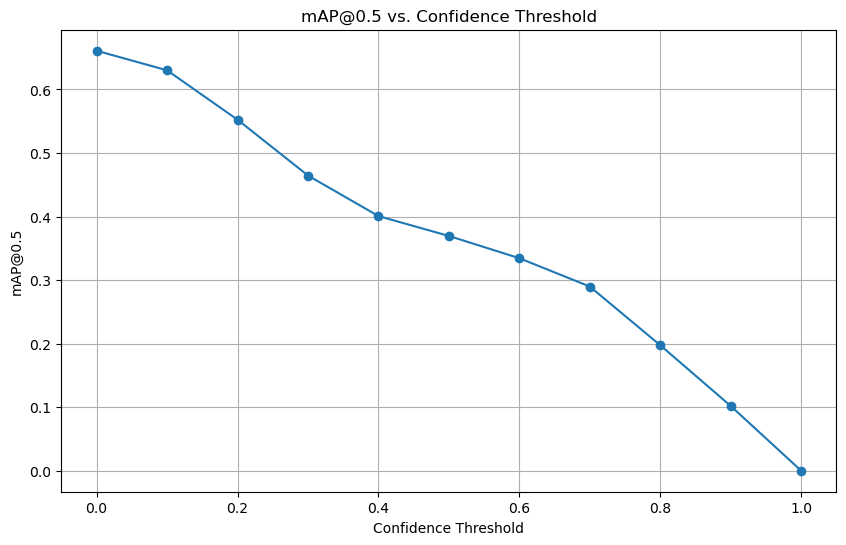

mAP@0.5 per Threshold:
Threshold: 0.0, mAP@0.5: 0.6609
Threshold: 0.1, mAP@0.5: 0.6301
Threshold: 0.2, mAP@0.5: 0.5524
Threshold: 0.3, mAP@0.5: 0.4645
Threshold: 0.4, mAP@0.5: 0.4007
Threshold: 0.5, mAP@0.5: 0.3694
Threshold: 0.6, mAP@0.5: 0.3344
Threshold: 0.7, mAP@0.5: 0.2898
Threshold: 0.8, mAP@0.5: 0.1975
Threshold: 0.9, mAP@0.5: 0.1019
Threshold: 1.0, mAP@0.5: 0.0000


In [8]:
# Computes the mean Average Precision (mAP@0.5) across all categories for each confidence threshold,
# then plots the mAP@0.5 curve.

thresholds = [round(x, 1) for x in np.arange(0.0, 1.01, 0.1)]
mAP50_per_threshold = {}
for threshold in thresholds:
    all_aps_at_threshold = []
    for category_name in ap50_scores:
        if ap50_scores[category_name][threshold]:
            all_aps_at_threshold.extend(ap50_scores[category_name][threshold])
    if all_aps_at_threshold:
        mAP50_per_threshold[threshold] = np.mean(all_aps_at_threshold)
    else:
        mAP50_per_threshold[threshold] = 0.0

thresholds_sorted = sorted(mAP50_per_threshold.keys())
mAP50_values = [mAP50_per_threshold[t] for t in thresholds_sorted]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_sorted, mAP50_values, marker='o')
plt.xlabel('Confidence Threshold')
plt.ylabel('mAP@0.5')
plt.title('mAP@0.5 vs. Confidence Threshold')
plt.grid(True)
plt.show()

print("mAP@0.5 per Threshold:")
for threshold, mAP50 in mAP50_per_threshold.items():
    print(f"Threshold: {threshold:.1f}, mAP@0.5: {mAP50:.4f}")

Catégories rares: 70
Catégories communes: 345
Catégories fréquentes: 389


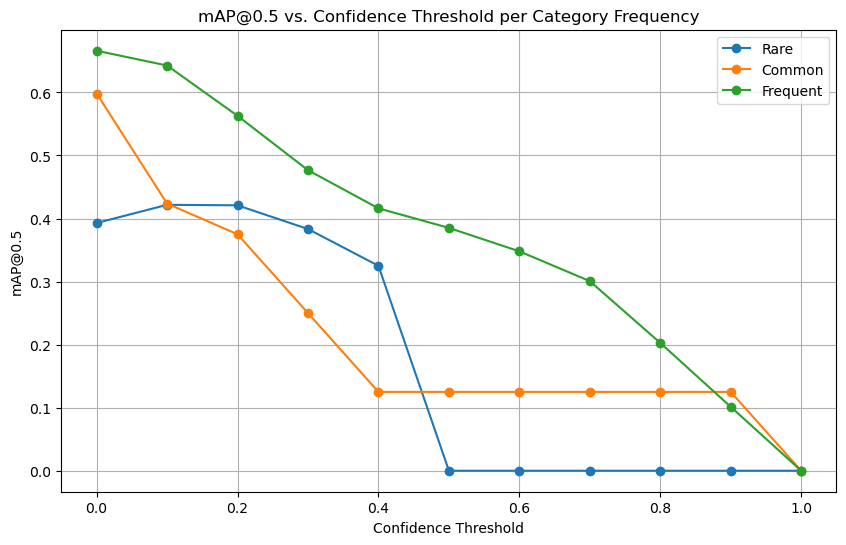


mAP@0.5 per Threshold for Rare Categories:
Threshold: 0.0, mAP@0.5: 0.3929
Threshold: 0.1, mAP@0.5: 0.4217
Threshold: 0.2, mAP@0.5: 0.4209
Threshold: 0.3, mAP@0.5: 0.3833
Threshold: 0.4, mAP@0.5: 0.3250
Threshold: 0.5, mAP@0.5: 0.0000
Threshold: 0.6, mAP@0.5: 0.0000
Threshold: 0.7, mAP@0.5: 0.0000
Threshold: 0.8, mAP@0.5: 0.0000
Threshold: 0.9, mAP@0.5: 0.0000
Threshold: 1.0, mAP@0.5: 0.0000

mAP@0.5 per Threshold for Common Categories:
Threshold: 0.0, mAP@0.5: 0.5983
Threshold: 0.1, mAP@0.5: 0.4236
Threshold: 0.2, mAP@0.5: 0.3750
Threshold: 0.3, mAP@0.5: 0.2500
Threshold: 0.4, mAP@0.5: 0.1250
Threshold: 0.5, mAP@0.5: 0.1250
Threshold: 0.6, mAP@0.5: 0.1250
Threshold: 0.7, mAP@0.5: 0.1250
Threshold: 0.8, mAP@0.5: 0.1250
Threshold: 0.9, mAP@0.5: 0.1250
Threshold: 1.0, mAP@0.5: 0.0000

mAP@0.5 per Threshold for Frequent Categories:
Threshold: 0.0, mAP@0.5: 0.6661
Threshold: 0.1, mAP@0.5: 0.6426
Threshold: 0.2, mAP@0.5: 0.5628
Threshold: 0.3, mAP@0.5: 0.4766
Threshold: 0.4, mAP@0.5: 0.416

In [9]:
def split_ap50_scores_by_frequency(ap50_scores, frequency_dict):
    """
    Splits AP50 scores into separate dictionaries based on category frequency.

    Args:
        ap50_scores (dict): Nested dict {category_name: {threshold: [ap_scores]}}.
        frequency_dict (dict): Dict with keys 'rare', 'common', 'frequent', each mapping to a set of category names.

    Returns:
        Tuple of defaultdicts: (rare_scores, common_scores, frequent_scores)
    """
    rare_scores = defaultdict(lambda: defaultdict(list))
    common_scores = defaultdict(lambda: defaultdict(list))
    frequent_scores = defaultdict(lambda: defaultdict(list))

    for category, thresholds_data in ap50_scores.items():
        if category in frequency_dict['rare']:
            target = rare_scores
        elif category in frequency_dict['common']:
            target = common_scores
        elif category in frequency_dict['frequent']:
            target = frequent_scores
        else:
            continue  # skip categories not in any group

        for threshold, aps in thresholds_data.items():
            target[category][threshold].extend(aps)

    return rare_scores, common_scores, frequent_scores


def compute_mAP50_per_threshold(scores_by_category, thresholds):
    """
    Computes mAP@0.5 per threshold across multiple categories.

    Args:
        scores_by_category (dict): Nested dict {category_name: {threshold: [ap_scores]}}.
        thresholds (list): List of thresholds to evaluate.

    Returns:
        dict: Mapping from threshold to averaged mAP@0.5 score.
    """
    mAP50_per_threshold = {}

    for threshold in thresholds:
        all_scores = []
        for category_scores in scores_by_category.values():
            all_scores.extend(category_scores.get(threshold, []))

        mAP50_per_threshold[threshold] = (
            np.mean(all_scores) if all_scores else 0.0
        )

    return mAP50_per_threshold


def plot_mAP_curves(mAP50_dicts, thresholds, labels):
    """
    Plots mAP@0.5 curves for different category frequency groups.

    Args:
        mAP50_dicts (list of dict): List of threshold->mAP50 dicts.
        thresholds (list): List of thresholds used.
        labels (list): Corresponding labels for each curve.
    """
    plt.figure(figsize=(10, 6))
    for mAP50, label in zip(mAP50_dicts, labels):
        sorted_thresh = sorted(mAP50.keys())
        sorted_mAP = [mAP50[t] for t in sorted_thresh]
        plt.plot(sorted_thresh, sorted_mAP, marker='o', label=label)

    plt.xlabel('Confidence Threshold')
    plt.ylabel('mAP@0.5')
    plt.title('mAP@0.5 vs. Confidence Threshold per Category Frequency')
    plt.grid(True)
    plt.legend()
    plt.show()


def print_mAP50(mAP50_per_threshold, label):
    """
    Prints the mAP@0.5 for each threshold.

    Args:
        mAP50_per_threshold (dict): Mapping threshold -> mAP50.
        label (str): Label describing the category group.
    """
    print(f"\nmAP@0.5 per Threshold for {label} Categories:")
    for threshold, score in mAP50_per_threshold.items():
        print(f"Threshold: {threshold:.1f}, mAP@0.5: {score:.4f}")

rare_categories = set()
common_categories = set()
frequent_categories = set()

for cat in lvis_val['categories']:
  freq = cat['frequency']
  if freq == 'r':
    rare_categories.add(cat['name'])
  elif freq == 'c':
    common_categories.add(cat['name'])
  elif freq == 'f':
    frequent_categories.add(cat['name'])

print(f"Catégories rares: {len(rare_categories)}")
print(f"Catégories communes: {len(common_categories)}")
print(f"Catégories fréquentes: {len(frequent_categories)}")

category_frequencies = {
    'rare': rare_categories,
    'common': common_categories,
    'frequent': frequent_categories
}

rare_scores, common_scores, frequent_scores = split_ap50_scores_by_frequency(
    ap50_scores, category_frequencies
)

rare_mAP50 = compute_mAP50_per_threshold(rare_scores, thresholds)
common_mAP50 = compute_mAP50_per_threshold(common_scores, thresholds)
frequent_mAP50 = compute_mAP50_per_threshold(frequent_scores, thresholds)

plot_mAP_curves(
    [rare_mAP50, common_mAP50, frequent_mAP50],
    thresholds,
    labels=['Rare', 'Common', 'Frequent']
)

print_mAP50(rare_mAP50, 'Rare')
print_mAP50(common_mAP50, 'Common')
print_mAP50(frequent_mAP50, 'Frequent')



Object Size Categories: 174 small, 89 normal, 541 large


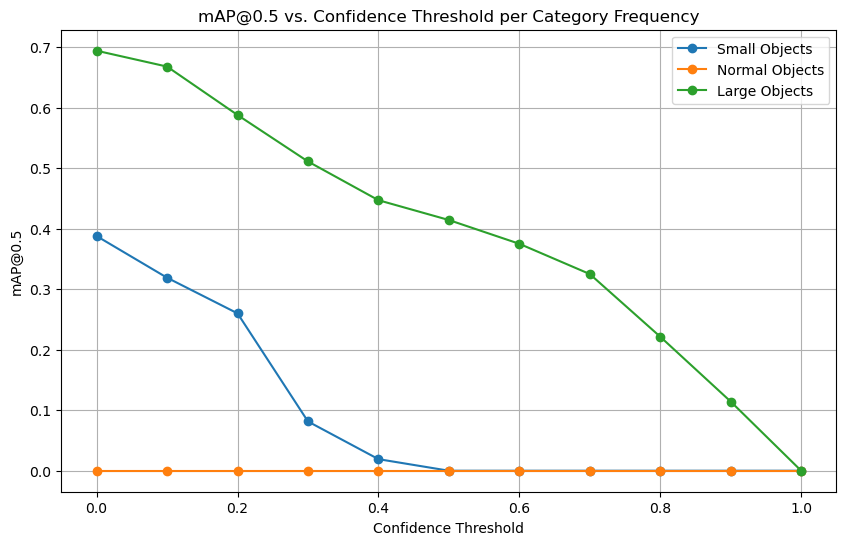


mAP@0.5 per Threshold for Small Objects Categories:
Threshold: 0.0, mAP@0.5: 0.3878
Threshold: 0.1, mAP@0.5: 0.3189
Threshold: 0.2, mAP@0.5: 0.2601
Threshold: 0.3, mAP@0.5: 0.0814
Threshold: 0.4, mAP@0.5: 0.0191
Threshold: 0.5, mAP@0.5: 0.0000
Threshold: 0.6, mAP@0.5: 0.0000
Threshold: 0.7, mAP@0.5: 0.0000
Threshold: 0.8, mAP@0.5: 0.0000
Threshold: 0.9, mAP@0.5: 0.0000
Threshold: 1.0, mAP@0.5: 0.0000

mAP@0.5 per Threshold for Normal Objects Categories:
Threshold: 0.0, mAP@0.5: 0.0000
Threshold: 0.1, mAP@0.5: 0.0000
Threshold: 0.2, mAP@0.5: 0.0000
Threshold: 0.3, mAP@0.5: 0.0000
Threshold: 0.4, mAP@0.5: 0.0000
Threshold: 0.5, mAP@0.5: 0.0000
Threshold: 0.6, mAP@0.5: 0.0000
Threshold: 0.7, mAP@0.5: 0.0000
Threshold: 0.8, mAP@0.5: 0.0000
Threshold: 0.9, mAP@0.5: 0.0000
Threshold: 1.0, mAP@0.5: 0.0000

mAP@0.5 per Threshold for Large Objects Categories:
Threshold: 0.0, mAP@0.5: 0.6941
Threshold: 0.1, mAP@0.5: 0.6678
Threshold: 0.2, mAP@0.5: 0.5879
Threshold: 0.3, mAP@0.5: 0.5110
Threshol

In [10]:
def categorize_categories_by_object_size(lvis_data, id_to_name, small_thresh=32*32, large_thresh=96*96):
    """
    Categorizes object categories into small, normal, and large based on average bounding box area.

    Args:
        lvis_data (dict): LVIS annotations data.
        id_to_name (dict): Mapping from category ID to name.
        small_thresh (int): Area threshold under which objects are considered small.
        large_thresh (int): Area threshold above which objects are considered large.

    Returns:
        dict: A dictionary with keys 'small', 'normal', 'large' each containing a set of category names.
    """
    small, normal, large = set(), set(), set()

    for ann in lvis_data['annotations']:
        area = ann['bbox'][2] * ann['bbox'][3]  # width * height
        category_name = id_to_name[ann['category_id']]
        if area < small_thresh:
            small.add(category_name)
        elif area > large_thresh:
            large.add(category_name)
        else:
            normal.add(category_name)

    # Ensure mutual exclusivity
    normal -= small | large
    small -= normal | large
    large -= small | normal

    return {'small': small, 'normal': normal, 'large': large}


def split_ap50_scores_by_object_size(ap50_scores, size_categories):
    """
    Splits AP50 scores by object size categories.

    Args:
        ap50_scores (dict): Nested dict {category_name: {threshold: [ap_scores]}}.
        size_categories (dict): Dict with keys 'small', 'normal', 'large', each a set of category names.

    Returns:
        Tuple of defaultdicts: (small_scores, normal_scores, large_scores)
    """
    small_scores = defaultdict(lambda: defaultdict(list))
    normal_scores = defaultdict(lambda: defaultdict(list))
    large_scores = defaultdict(lambda: defaultdict(list))

    for category, thresholds_data in ap50_scores.items():
        if category in size_categories['small']:
            target = small_scores
        elif category in size_categories['normal']:
            target = normal_scores
        elif category in size_categories['large']:
            target = large_scores
        else:
            continue

        for threshold, aps in thresholds_data.items():
            target[category][threshold].extend(aps)

    return small_scores, normal_scores, large_scores

# Step 1: Categorize by object size
id_to_name = get_category_mapping(lvis_val)
object_size_categories = categorize_categories_by_object_size(lvis_val, id_to_name)
print(f"Object Size Categories: {len(object_size_categories['small'])} small, "
      f"{len(object_size_categories['normal'])} normal, "
        f"{len(object_size_categories['large'])} large")

# Step 2: Split AP50 scores by size category
small_scores, normal_scores, large_scores = split_ap50_scores_by_object_size(ap50_scores, object_size_categories)

# Step 3: Compute mAP@0.5 curves
small_mAP50 = compute_mAP50_per_threshold(small_scores, thresholds)
normal_mAP50 = compute_mAP50_per_threshold(normal_scores, thresholds)
large_mAP50 = compute_mAP50_per_threshold(large_scores, thresholds)

# Step 4: Plot
plot_mAP_curves(
    [small_mAP50, normal_mAP50, large_mAP50],
    thresholds,
    labels=['Small Objects', 'Normal Objects', 'Large Objects']
)

# Step 5: Print results
print_mAP50(small_mAP50, 'Small Objects')
print_mAP50(normal_mAP50, 'Normal Objects')
print_mAP50(large_mAP50, 'Large Objects')



Nombre de catégories vues : 752
Nombre de catégories non vues : 50


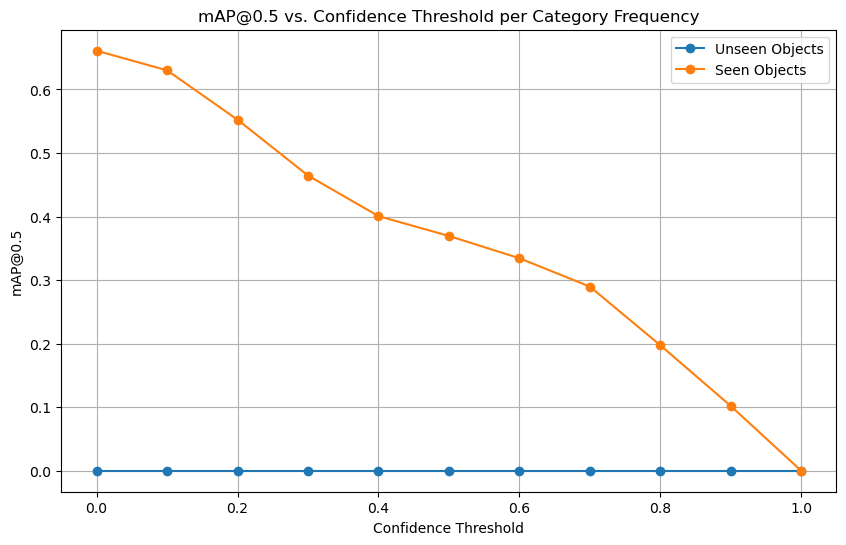


mAP@0.5 per Threshold for Seen Objects Categories:
Threshold: 0.0, mAP@0.5: 0.6609
Threshold: 0.1, mAP@0.5: 0.6301
Threshold: 0.2, mAP@0.5: 0.5524
Threshold: 0.3, mAP@0.5: 0.4645
Threshold: 0.4, mAP@0.5: 0.4007
Threshold: 0.5, mAP@0.5: 0.3694
Threshold: 0.6, mAP@0.5: 0.3344
Threshold: 0.7, mAP@0.5: 0.2898
Threshold: 0.8, mAP@0.5: 0.1975
Threshold: 0.9, mAP@0.5: 0.1019
Threshold: 1.0, mAP@0.5: 0.0000

mAP@0.5 per Threshold for Unseen Objects Categories:
Threshold: 0.0, mAP@0.5: 0.0000
Threshold: 0.1, mAP@0.5: 0.0000
Threshold: 0.2, mAP@0.5: 0.0000
Threshold: 0.3, mAP@0.5: 0.0000
Threshold: 0.4, mAP@0.5: 0.0000
Threshold: 0.5, mAP@0.5: 0.0000
Threshold: 0.6, mAP@0.5: 0.0000
Threshold: 0.7, mAP@0.5: 0.0000
Threshold: 0.8, mAP@0.5: 0.0000
Threshold: 0.9, mAP@0.5: 0.0000
Threshold: 1.0, mAP@0.5: 0.0000


In [11]:
def split_ap50_scores_by_seen_status(ap50_scores, seen_categories, unseen_categories, clean_fn):
    """
    Splits AP50 scores into seen and unseen categories based on cleaned names.

    Args:
        ap50_scores (dict): Nested dict {category_name: {threshold: [ap_scores]}}.
        seen_categories (set): Set of cleaned names of seen categories.
        unseen_categories (set): Set of cleaned names of unseen categories.
        clean_fn (function): Function to clean/normalize category names.

    Returns:
        Tuple of defaultdicts: (seen_scores, unseen_scores)
    """
    seen_scores = defaultdict(lambda: defaultdict(list))
    unseen_scores = defaultdict(lambda: defaultdict(list))

    for category, thresholds_data in ap50_scores.items():
        clean_name = clean_fn(category)
        if clean_name in unseen_categories:
            target = unseen_scores
        elif clean_name in seen_categories:
            target = seen_scores
        else:
            continue

        for threshold, aps in thresholds_data.items():
            target[category][threshold].extend(aps)

    return seen_scores, unseen_scores


print("Nombre de catégories vues :", len(seen_categories))
print("Nombre de catégories non vues :", len(unseen_categories))
# Step 1: Split scores by seen/unseen
seen_scores, unseen_scores = split_ap50_scores_by_seen_status(
    ap50_scores, seen_categories, unseen_categories, clean_category
)

# Step 2: Compute mAP curves
seen_mAP50 = compute_mAP50_per_threshold(seen_scores, thresholds)
unseen_mAP50 = compute_mAP50_per_threshold(unseen_scores, thresholds)

# Step 3: Plot
plot_mAP_curves(
    [unseen_mAP50, seen_mAP50],
    thresholds,
    labels=['Unseen Objects', 'Seen Objects']
)

# Step 4: Print
print_mAP50(seen_mAP50, 'Seen Objects')
print_mAP50(unseen_mAP50, 'Unseen Objects')


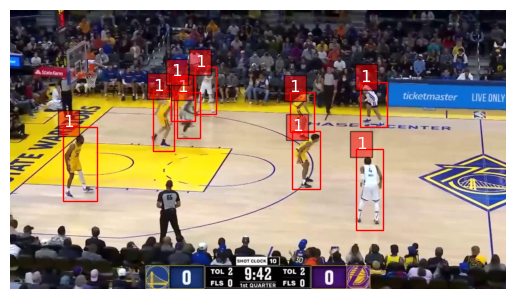

Images : 44
Annotations : 403
Categories : 1


In [12]:
# Import BasketBall dataset
with open(r"..\Dataset\bball_yolo_5-10-23-1\train\_annotations.coco.json", "r") as f:
    basket_val = json.load(f)

img_path = basket_val['images'][0]['file_name']
img = Image.open(r"..\Dataset\bball_yolo_5-10-23-1\train\\" + img_path)
plt.imshow(img)
annotations = basket_val['annotations']
for ann in annotations:
    if ann['image_id'] == basket_val['images'][0]['id']:
        bbox = ann['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(bbox[0], bbox[1], ann['category_id'], color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
plt.axis('off')
plt.show()

categories = set()
for cat in basket_val['categories']:
    categories.add(cat['supercategory'])

print(f"Images : {len(basket_val['images'])}")
print(f"Annotations : {len(basket_val['annotations'])}")
print(f"Categories : {len(basket_val['categories'])-1}")

In [13]:
# Predict AP50 score for each category across the Basket dataset

def process_image(image, data, model, id_to_name, thresholds, ap50_scores):
    """
        Runs inference on a single image, computes AP scores across all thresholds
        for each ground-truth category, and updates the AP score dictionary.

        Args:
            image (dict): Image metadata dict from JSON dataset.
            data (dict): JSON dataset.
            model (YOLOE): Initialized detection model.
            id_to_name (dict): Category ID to name mapping.
            thresholds (list): List of confidence thresholds to evaluate.
            ap50_scores (defaultdict): Nested dict to store AP scores.
    """
    img_path = image['file_name']
    img = Image.open(r"..\Dataset\bball_yolo_5-10-23-1\train\\" + img_path).convert("RGB")

    annotations = get_annotations_by_image(data, image['id'])
    category_to_boxes = group_boxes_by_category(annotations, id_to_name)
    categories = list(category_to_boxes.keys())

    model.set_classes(categories, model.get_text_pe(categories))
    result = model.predict(img, conf=0.001, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)

    for category_name, gt_boxes in category_to_boxes.items():
        for threshold in thresholds:
            pred_boxes = []
            pred_scores = []

            for label, score, box in zip(detections['class_name'], detections.confidence, detections.xyxy):
                if label == category_name and score >= threshold:
                    pred_boxes.append(box)
                    pred_scores.append(score)

            ap = compute_ap(gt_boxes, pred_boxes, pred_scores)
            ap50_scores[category_name][threshold].append(ap)

def evaluate_dataset(data, model_path, max_images=5):
    """
        Evaluates a detection model on a subset of the JSON dataset by computing
        AP@0.5 scores per category across multiple confidence thresholds.

        Args:
            data (dict): JSON dataset.
            model_path (str): Path to the pretrained YOLOE model.
            max_images (int): Maximum number of images to evaluate.

        Returns:
            dict: Nested dictionary {category_name: {threshold: [AP scores]}}.
    """
    ap50_scores = defaultdict(lambda: defaultdict(list))
    id_to_name = get_category_mapping(data)
    thresholds = [round(x, 1) for x in np.arange(0.0, 1.01, 0.1)]

    for image in tqdm(data['images'][:max_images]):
        model = YOLOE(model_path)
        # model.to("cuda")
        process_image(image, data, model, id_to_name, thresholds, ap50_scores)

    return ap50_scores


100%|██████████| 44/44 [02:01<00:00,  2.76s/it]


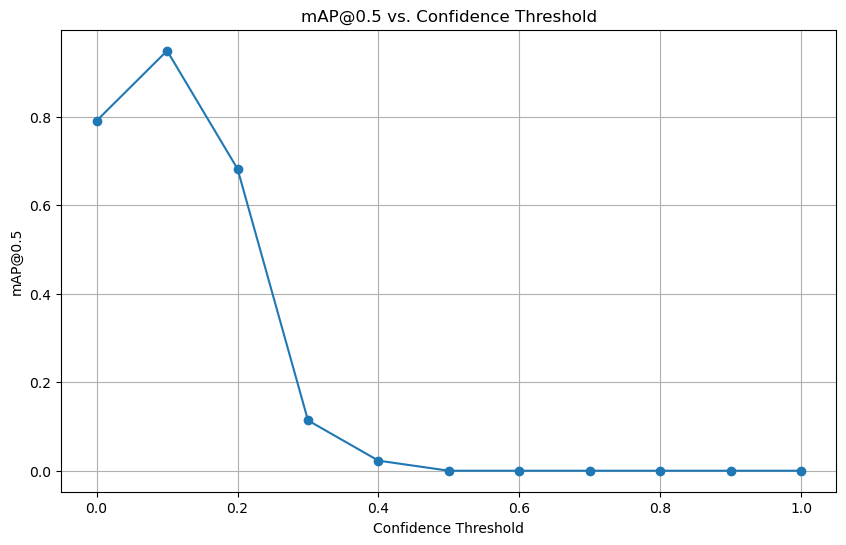

mAP@0.5 per Threshold:
Threshold: 0.0, mAP@0.5: 0.7905
Threshold: 0.1, mAP@0.5: 0.9487
Threshold: 0.2, mAP@0.5: 0.6818
Threshold: 0.3, mAP@0.5: 0.1136
Threshold: 0.4, mAP@0.5: 0.0227
Threshold: 0.5, mAP@0.5: 0.0000
Threshold: 0.6, mAP@0.5: 0.0000
Threshold: 0.7, mAP@0.5: 0.0000
Threshold: 0.8, mAP@0.5: 0.0000
Threshold: 0.9, mAP@0.5: 0.0000
Threshold: 1.0, mAP@0.5: 0.0000


In [14]:
ap50_scores = evaluate_dataset(basket_val, "pretrain/yoloe-v8l-seg.pt", max_images=44)

thresholds = [round(x, 1) for x in np.arange(0.0, 1.01, 0.1)]
mAP50_per_threshold = {}
for threshold in thresholds:
    all_aps_at_threshold = []
    for category_name in ap50_scores:
        if ap50_scores[category_name][threshold]:
            all_aps_at_threshold.extend(ap50_scores[category_name][threshold])
    if all_aps_at_threshold:
        mAP50_per_threshold[threshold] = np.mean(all_aps_at_threshold)
    else:
        mAP50_per_threshold[threshold] = 0.0

thresholds_sorted = sorted(mAP50_per_threshold.keys())
mAP50_values = [mAP50_per_threshold[t] for t in thresholds_sorted]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_sorted, mAP50_values, marker='o')
plt.xlabel('Confidence Threshold')
plt.ylabel('mAP@0.5')
plt.title('mAP@0.5 vs. Confidence Threshold')
plt.grid(True)
plt.show()

print("mAP@0.5 per Threshold:")
for threshold, mAP50 in mAP50_per_threshold.items():
    print(f"Threshold: {threshold:.1f}, mAP@0.5: {mAP50:.4f}")


In [15]:
# Retrieve categories from the unseen categories of the LVIS dataset
def retrieve_categories_from_unseen(unseen_categories, lvis_data):
    """
    Retrieves categories from the unseen categories of the LVIS dataset.

    Args:
        unseen_categories (set): Set of unseen category names.
        lvis_data (dict): LVIS dataset containing categories.

    Returns:
        set: Set of categories that match the unseen categories.
    """
    matched_categories = set()
    for cat in lvis_data['categories']:
        cleaned_name = clean_category(cat['name'])
        if cleaned_name in unseen_categories:
            matched_categories.add(cat['name'])
    return matched_categories

# Retrieve unseen categories from the LVIS dataset
unseen_categories_from_lvis = retrieve_categories_from_unseen(unseen_categories, lvis_val)
print(f"Unseen categories from LVIS dataset: {len(unseen_categories_from_lvis)}")

# Retrieve sub-dataset of lvis dataset with unseen categories
def filter_lvis_by_unseen_categories_full(lvis_data, unseen_categories):
    """
    Retourne un sous-dataset LVIS contenant :
    - toutes les images ayant au moins une annotation d'une catégorie non vue,
    - toutes les annotations de ces images (vues et non vues),
    - toutes les catégories présentes dans ces annotations.
    """
    unseen_cat_ids = {cat['id'] for cat in lvis_data['categories'] if clean_category(cat['name']) in unseen_categories}

    image_ids_with_unseen = {ann['image_id'] for ann in lvis_data['annotations'] if ann['category_id'] in unseen_cat_ids}

    filtered_images = [img for img in lvis_data['images'] if img['id'] in image_ids_with_unseen]

    filtered_annotations = [ann for ann in lvis_data['annotations'] if ann['image_id'] in image_ids_with_unseen]

    cat_ids_in_annotations = {ann['category_id'] for ann in filtered_annotations}
    filtered_categories = [cat for cat in lvis_data['categories'] if cat['id'] in cat_ids_in_annotations]

    return {
        "images": filtered_images,
        "annotations": filtered_annotations,
        "categories": filtered_categories
    }

unseen_lvis_data = filter_lvis_by_unseen_categories_full(lvis_val, unseen_categories)
print(f"Filtered LVIS dataset with unseen categories: {len(unseen_lvis_data['images'])} images,{len(unseen_lvis_data['annotations'])} annotations, {len(unseen_lvis_data['categories'])} categories")

Unseen categories from LVIS dataset: 50
Filtered LVIS dataset with unseen categories: 210 images,2841 annotations, 343 categories


In [18]:
# Predict AP50 score for each category across the Basket dataset

def process_image(image, data, model, id_to_name, thresholds, ap50_scores):
    """
        Runs inference on a single image, computes AP scores across all thresholds
        for each ground-truth category, and updates the AP score dictionary.

        Args:
            image (dict): Image metadata dict from JSON dataset.
            data (dict): JSON dataset.
            model (YOLOE): Initialized detection model.
            id_to_name (dict): Category ID to name mapping.
            thresholds (list): List of confidence thresholds to evaluate.
            ap50_scores (defaultdict): Nested dict to store AP scores.
    """
    response = requests.get(image['coco_url'])
    img = Image.open(BytesIO(response.content)).convert("RGB")

    annotations = get_annotations_by_image(data, image['id'])
    category_to_boxes = group_boxes_by_category(annotations, id_to_name)
    categories = list(category_to_boxes.keys())

    model.set_classes(categories, model.get_text_pe(categories))
    result = model.predict(img, conf=0.001, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)

    for category_name, gt_boxes in category_to_boxes.items():
        for threshold in thresholds:
            pred_boxes = []
            pred_scores = []

            for label, score, box in zip(detections['class_name'], detections.confidence, detections.xyxy):
                if label == category_name and score >= threshold:
                    pred_boxes.append(box)
                    pred_scores.append(score)

            ap = compute_ap(gt_boxes, pred_boxes, pred_scores)
            ap50_scores[category_name][threshold].append(ap)

def evaluate_dataset(data, model_path, max_images=5):
    """
        Evaluates a detection model on a subset of the JSON dataset by computing
        AP@0.5 scores per category across multiple confidence thresholds.

        Args:
            data (dict): JSON dataset.
            model_path (str): Path to the pretrained YOLOE model.
            max_images (int): Maximum number of images to evaluate.

        Returns:
            dict: Nested dictionary {category_name: {threshold: [AP scores]}}.
    """
    ap50_scores = defaultdict(lambda: defaultdict(list))
    id_to_name = get_category_mapping(data)
    thresholds = [round(x, 1) for x in np.arange(0.0, 1.01, 0.1)]

    for image in tqdm(data['images'][:max_images]):
        model = YOLOE(model_path)
        # model.to("cuda")
        process_image(image, data, model, id_to_name, thresholds, ap50_scores)

    return ap50_scores


100%|██████████| 210/210 [12:51<00:00,  3.68s/it]


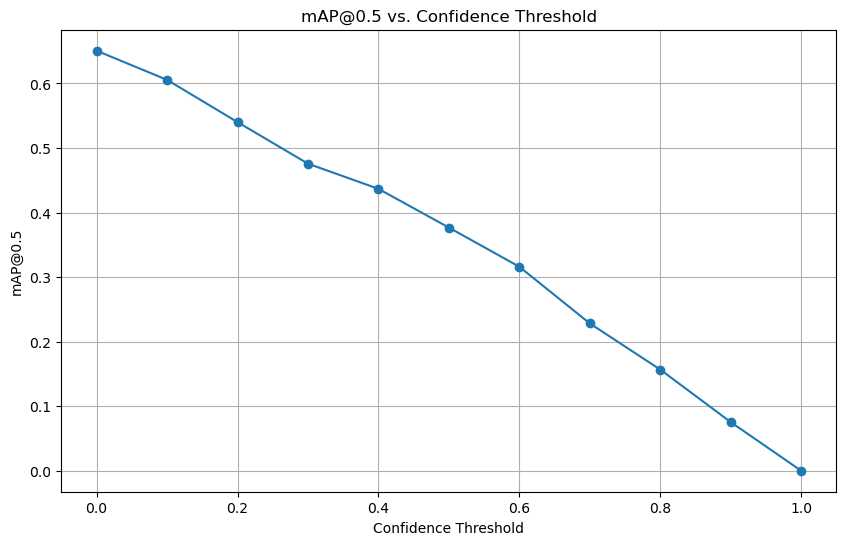

mAP@0.5 per Threshold:
Threshold: 0.0, mAP@0.5: 0.6507
Threshold: 0.1, mAP@0.5: 0.6056
Threshold: 0.2, mAP@0.5: 0.5401
Threshold: 0.3, mAP@0.5: 0.4757
Threshold: 0.4, mAP@0.5: 0.4367
Threshold: 0.5, mAP@0.5: 0.3767
Threshold: 0.6, mAP@0.5: 0.3160
Threshold: 0.7, mAP@0.5: 0.2282
Threshold: 0.8, mAP@0.5: 0.1567
Threshold: 0.9, mAP@0.5: 0.0753
Threshold: 1.0, mAP@0.5: 0.0000


In [19]:
ap50_scores = evaluate_dataset(unseen_lvis_data, "pretrain/yoloe-v8l-seg.pt", max_images=243)

thresholds = [round(x, 1) for x in np.arange(0.0, 1.01, 0.1)]
mAP50_per_threshold = {}
for threshold in thresholds:
    all_aps_at_threshold = []
    for category_name in ap50_scores:
        if ap50_scores[category_name][threshold]:
            all_aps_at_threshold.extend(ap50_scores[category_name][threshold])
    if all_aps_at_threshold:
        mAP50_per_threshold[threshold] = np.mean(all_aps_at_threshold)
    else:
        mAP50_per_threshold[threshold] = 0.0

thresholds_sorted = sorted(mAP50_per_threshold.keys())
mAP50_values = [mAP50_per_threshold[t] for t in thresholds_sorted]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_sorted, mAP50_values, marker='o')
plt.xlabel('Confidence Threshold')
plt.ylabel('mAP@0.5')
plt.title('mAP@0.5 vs. Confidence Threshold')
plt.grid(True)
plt.show()

print("mAP@0.5 per Threshold:")
for threshold, mAP50 in mAP50_per_threshold.items():
    print(f"Threshold: {threshold:.1f}, mAP@0.5: {mAP50:.4f}")


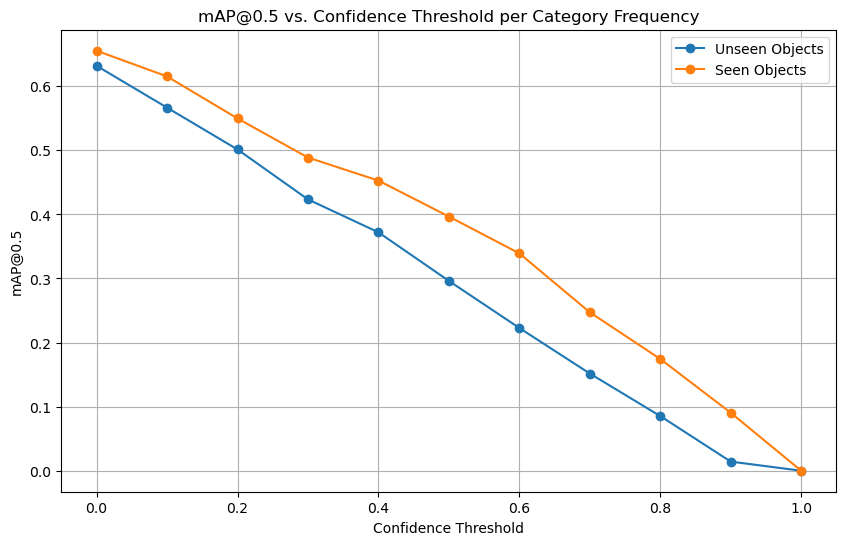


mAP@0.5 per Threshold for Seen Objects Categories:
Threshold: 0.0, mAP@0.5: 0.6554
Threshold: 0.1, mAP@0.5: 0.6153
Threshold: 0.2, mAP@0.5: 0.5497
Threshold: 0.3, mAP@0.5: 0.4887
Threshold: 0.4, mAP@0.5: 0.4528
Threshold: 0.5, mAP@0.5: 0.3967
Threshold: 0.6, mAP@0.5: 0.3391
Threshold: 0.7, mAP@0.5: 0.2472
Threshold: 0.8, mAP@0.5: 0.1744
Threshold: 0.9, mAP@0.5: 0.0904
Threshold: 1.0, mAP@0.5: 0.0000

mAP@0.5 per Threshold for Unseen Objects Categories:
Threshold: 0.0, mAP@0.5: 0.6318
Threshold: 0.1, mAP@0.5: 0.5666
Threshold: 0.2, mAP@0.5: 0.5013
Threshold: 0.3, mAP@0.5: 0.4234
Threshold: 0.4, mAP@0.5: 0.3720
Threshold: 0.5, mAP@0.5: 0.2962
Threshold: 0.6, mAP@0.5: 0.2227
Threshold: 0.7, mAP@0.5: 0.1517
Threshold: 0.8, mAP@0.5: 0.0853
Threshold: 0.9, mAP@0.5: 0.0142
Threshold: 1.0, mAP@0.5: 0.0000


In [20]:

seen_scores, unseen_scores = split_ap50_scores_by_seen_status(
    ap50_scores, seen_categories, unseen_categories, clean_category
)

seen_mAP50 = compute_mAP50_per_threshold(seen_scores, thresholds)
unseen_mAP50 = compute_mAP50_per_threshold(unseen_scores, thresholds)

plot_mAP_curves(
    [unseen_mAP50, seen_mAP50],
    thresholds,
    labels=['Unseen Objects', 'Seen Objects']
)

print_mAP50(seen_mAP50, 'Seen Objects')
print_mAP50(unseen_mAP50, 'Unseen Objects')


In [21]:
unseen_categories

{'atomizer',
 'automatic washer',
 'boom microphone',
 'brassiere',
 'bread-bin',
 'brussels sprouts',
 'cabin car',
 'cantaloup',
 'cellular telephone',
 'cigarette case',
 'cincture',
 'cleansing agent',
 'clothes hamper',
 'coatrack',
 'crescent roll',
 'dish antenna',
 'dixie cup',
 'domestic ass',
 'edible corn',
 'eggbeater',
 'gameboard',
 'giant panda',
 'gift wrap',
 'hair curler',
 'identity card',
 'life buoy',
 'mandarin orange',
 'mashed potato',
 'mint candy',
 'nightshirt',
 'noseband',
 'oil lamp',
 'pepper mill',
 'phonograph record',
 'piggy bank',
 'postbox',
 'prawn',
 'radio receiver',
 'reamer',
 'roller skate',
 'ski parka',
 'solar array',
 'soupspoon',
 'thermos bottle',
 'tobacco pipe',
 'trophy cup',
 'underdrawers',
 'water scooter',
 'wind chime',
 'wine bucket'}

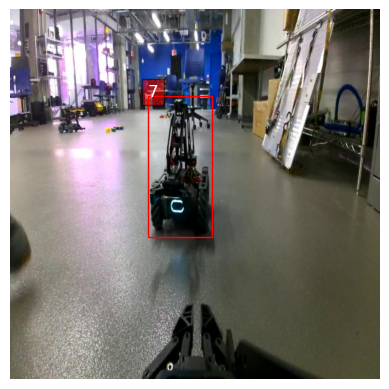

Images : 366
Annotations : 1432
Categories : 8
[{'id': 0, 'name': 'Legos', 'supercategory': 'none'}, {'id': 1, 'name': 'Goal A', 'supercategory': 'Legos'}, {'id': 2, 'name': 'Goal B', 'supercategory': 'Legos'}, {'id': 3, 'name': 'Lego', 'supercategory': 'Legos'}, {'id': 4, 'name': 'Obstacle', 'supercategory': 'Legos'}, {'id': 5, 'name': 'bar', 'supercategory': 'Legos'}, {'id': 6, 'name': 'river', 'supercategory': 'Legos'}, {'id': 7, 'name': 'robot', 'supercategory': 'Legos'}]


In [22]:
# Import Lego dataset
with open(r"..\Dataset\Final-Project-Model-14\valid\_annotations.coco.json", "r") as f:
    Lego_val = json.load(f)

img_path = Lego_val['images'][0]['file_name']
img = Image.open(r"..\Dataset\Final-Project-Model-14\valid\\" + img_path)
plt.imshow(img)
annotations = Lego_val['annotations']
for ann in annotations:
    if ann['image_id'] == Lego_val['images'][0]['id']:
        bbox = ann['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(bbox[0], bbox[1], ann['category_id'], color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
plt.axis('off')
plt.show()

categories = set()
for cat in Lego_val['categories']:
    categories.add(cat['name'])

print(f"Images : {len(Lego_val['images'])}")
print(f"Annotations : {len(Lego_val['annotations'])}")
print(f"Categories : {len(Lego_val['categories'])}")

print(Lego_val['categories'])

In [23]:
for cat in Lego_val['categories']:
    if cat['name'] == 'Lego':
        lego_cat = cat
        break

filtered_annotations = []
filtered_images = set()
for ann in Lego_val['annotations']:
    if ann['category_id'] == lego_cat['id']:
        filtered_annotations.append(ann)
        filtered_images.add(ann['image_id'])

filtered_images = [img for img in Lego_val['images'] if img['id'] in filtered_images]

lego_dataset = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": [lego_cat]
}

print(f"Filtered Lego dataset: {len(lego_dataset['images'])} images, {len(lego_dataset['annotations'])} annotations, {len(lego_dataset['categories'])} categories")

Filtered Lego dataset: 137 images, 1062 annotations, 1 categories


In [24]:
# Predict AP50 score for each category across the Basket dataset

def process_image(image, data, model, id_to_name, thresholds, ap50_scores):
    """
        Runs inference on a single image, computes AP scores across all thresholds
        for each ground-truth category, and updates the AP score dictionary.

        Args:
            image (dict): Image metadata dict from JSON dataset.
            data (dict): JSON dataset.
            model (YOLOE): Initialized detection model.
            id_to_name (dict): Category ID to name mapping.
            thresholds (list): List of confidence thresholds to evaluate.
            ap50_scores (defaultdict): Nested dict to store AP scores.
    """
    img_path = image['file_name']
    img = Image.open(r"..\Dataset\Final-Project-Model-14\valid\\" + img_path).convert("RGB")

    annotations = get_annotations_by_image(data, image['id'])
    category_to_boxes = group_boxes_by_category(annotations, id_to_name)
    categories = list(category_to_boxes.keys())

    model.set_classes(categories, model.get_text_pe(categories))
    result = model.predict(img, conf=0.001, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)

    for category_name, gt_boxes in category_to_boxes.items():
        for threshold in thresholds:
            pred_boxes = []
            pred_scores = []

            for label, score, box in zip(detections['class_name'], detections.confidence, detections.xyxy):
                if label == category_name and score >= threshold:
                    pred_boxes.append(box)
                    pred_scores.append(score)

            ap = compute_ap(gt_boxes, pred_boxes, pred_scores)
            ap50_scores[category_name][threshold].append(ap)

def evaluate_dataset(data, model_path, max_images=5):
    """
        Evaluates a detection model on a subset of the JSON dataset by computing
        AP@0.5 scores per category across multiple confidence thresholds.

        Args:
            data (dict): JSON dataset.
            model_path (str): Path to the pretrained YOLOE model.
            max_images (int): Maximum number of images to evaluate.

        Returns:
            dict: Nested dictionary {category_name: {threshold: [AP scores]}}.
    """
    ap50_scores = defaultdict(lambda: defaultdict(list))
    id_to_name = get_category_mapping(data)
    thresholds = [round(x, 1) for x in np.arange(0.0, 1.01, 0.1)]

    for image in tqdm(data['images'][:max_images]):
        model = YOLOE(model_path)
        # model.to("cuda")
        process_image(image, data, model, id_to_name, thresholds, ap50_scores)

    return ap50_scores


100%|██████████| 137/137 [07:03<00:00,  3.09s/it]


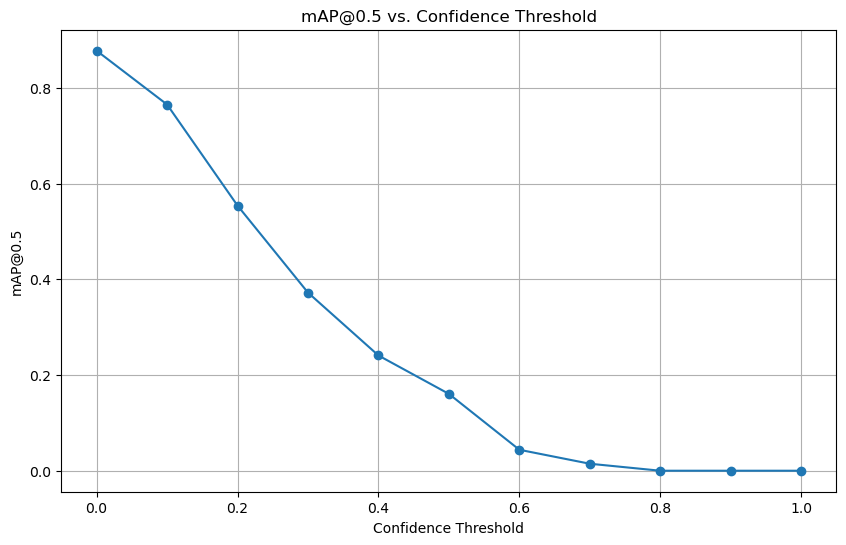

mAP@0.5 per Threshold:
Threshold: 0.0, mAP@0.5: 0.8779
Threshold: 0.1, mAP@0.5: 0.7654
Threshold: 0.2, mAP@0.5: 0.5541
Threshold: 0.3, mAP@0.5: 0.3723
Threshold: 0.4, mAP@0.5: 0.2409
Threshold: 0.5, mAP@0.5: 0.1606
Threshold: 0.6, mAP@0.5: 0.0438
Threshold: 0.7, mAP@0.5: 0.0146
Threshold: 0.8, mAP@0.5: 0.0000
Threshold: 0.9, mAP@0.5: 0.0000
Threshold: 1.0, mAP@0.5: 0.0000


In [25]:
ap50_scores = evaluate_dataset(lego_dataset, "pretrain/yoloe-v8l-seg.pt", max_images=137)

thresholds = [round(x, 1) for x in np.arange(0.0, 1.01, 0.1)]
mAP50_per_threshold = {}
for threshold in thresholds:
    all_aps_at_threshold = []
    for category_name in ap50_scores:
        if ap50_scores[category_name][threshold]:
            all_aps_at_threshold.extend(ap50_scores[category_name][threshold])
    if all_aps_at_threshold:
        mAP50_per_threshold[threshold] = np.mean(all_aps_at_threshold)
    else:
        mAP50_per_threshold[threshold] = 0.0

thresholds_sorted = sorted(mAP50_per_threshold.keys())
mAP50_values = [mAP50_per_threshold[t] for t in thresholds_sorted]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_sorted, mAP50_values, marker='o')
plt.xlabel('Confidence Threshold')
plt.ylabel('mAP@0.5')
plt.title('mAP@0.5 vs. Confidence Threshold')
plt.grid(True)
plt.show()

print("mAP@0.5 per Threshold:")
for threshold, mAP50 in mAP50_per_threshold.items():
    print(f"Threshold: {threshold:.1f}, mAP@0.5: {mAP50:.4f}")
